<a href="https://colab.research.google.com/github/aks2093/corona-Data-analysis-and-prediction/blob/master/time_series_model_confirmed_cases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from copy import deepcopy
import numpy as np

data_dir = "/content/drive/My Drive/vumonic"
latest = os.path.join(data_dir, "07-12-2020.csv")
confirmed = os.path.join(data_dir, "time_series_covid19_confirmed_global.csv")
deaths = os.path.join(data_dir, "time_series_covid19_deaths_global.csv")
recovered = os.path.join(data_dir, "time_series_covid19_recovered_global.csv")
csse_daily = os.path.join(data_dir, "csse_daily.csv")
population = os.path.join(data_dir, "population_by_country_2020.csv") #data source: https://www.kaggle.com/tanuprabhu/population-by-country-2020

latest = pd.read_csv(latest)
confirmed = pd.read_csv(confirmed)
deaths = pd.read_csv(deaths)
recovered = pd.read_csv(recovered)
csse_daily = pd.read_csv(csse_daily)
population = pd.read_csv(population)

print("Data Import Done")


Data Import Done


In [ ]:
latest.columns

In [ ]:
csse_daily.columns

In [ ]:
population.columns

In [ ]:
population.isna().sum()

In [ ]:
population["Country (or dependency)"]

In [ ]:
#predict
#countrywise new cases
#countrywise new deaths
#countrywise new recoveries

# Building a Time series model for confirmed cases

**Approach**: 

1. Here we are trying to predict daily increase in the confirmed cases.
2. will keep last 7 days for forecast
3. we will skip the timeline 22nd-Jan to 15th-Feb for all countries except china, and train our time series model on data starting from 16th Feb.

In [63]:
excluded_columns = ['Province/State', 'Lat', 'Long']

required_confirmed_word_wide_data = confirmed.drop(excluded_columns, axis=1)
country_wise_confirmed_cases = required_confirmed_word_wide_data.groupby(["Country/Region"]).sum().reset_index()


countries = country_wise_confirmed_cases[["Country/Region"]]
countries["Country/Region"] = countries["Country/Region"].apply(lambda x:x.lower())

country_wise_confirmed_cases = country_wise_confirmed_cases.drop("Country/Region", axis=1)



daily_increase_in_confirmed_cases = country_wise_confirmed_cases.diff(axis = 1, periods = 1)
daily_increase_in_confirmed_cases = daily_increase_in_confirmed_cases.fillna(0)
daily_increase_in_confirmed_cases = pd.concat([countries, daily_increase_in_confirmed_cases ], axis=1)

print(daily_increase_in_confirmed_cases)


         Country/Region  1/22/20  1/23/20  ...  7/11/20  7/12/20  7/13/20
0           afghanistan      0.0      0.0  ...    172.0     85.0      4.0
1               albania      0.0      0.0  ...     93.0     83.0    117.0
2               algeria      0.0      0.0  ...    470.0    483.0    494.0
3               andorra      0.0      0.0  ...      0.0      0.0      3.0
4                angola      0.0      0.0  ...      4.0     44.0     19.0
..                  ...      ...      ...  ...      ...      ...      ...
183  west bank and gaza      0.0      0.0  ...    380.0    299.0    336.0
184      western sahara      0.0      0.0  ...      0.0      0.0      0.0
185               yemen      0.0      0.0  ...      9.0     76.0     33.0
186              zambia      0.0      0.0  ...      0.0      0.0      0.0
187            zimbabwe      0.0      0.0  ...     40.0      3.0     49.0

[188 rows x 175 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from matplotlib import pyplot as plt

daily_increase_in_confirmed_cases["Country/Region"] = daily_increase_in_confirmed_cases["Country/Region"].apply(lambda x: x.lower())

#taking increment in confirmed cases after 15 Feb except "China" 
#exluding last 7 days for test forecasting
last_7_days_for_forecasting = daily_increase_in_confirmed_cases.columns.to_list()[168:]
before_16_feb_columns = daily_increase_in_confirmed_cases.columns.to_list()[1:26]
drop_columns =  before_16_feb_columns + last_7_days_for_forecasting

daily_increase_in_confirmed_cases_after_16_feb = daily_increase_in_confirmed_cases.drop(before_16_feb_columns, axis=1)
print(daily_increase_in_confirmed_cases_after_16_feb.columns)

# result_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')



Index(['Country/Region', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20',
       '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       ...
       '7/4/20', '7/5/20', '7/6/20', '7/7/20', '7/8/20', '7/9/20', '7/10/20',
       '7/11/20', '7/12/20', '7/13/20'],
      dtype='object', length=150)


**Seasonal Decomposition for china**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

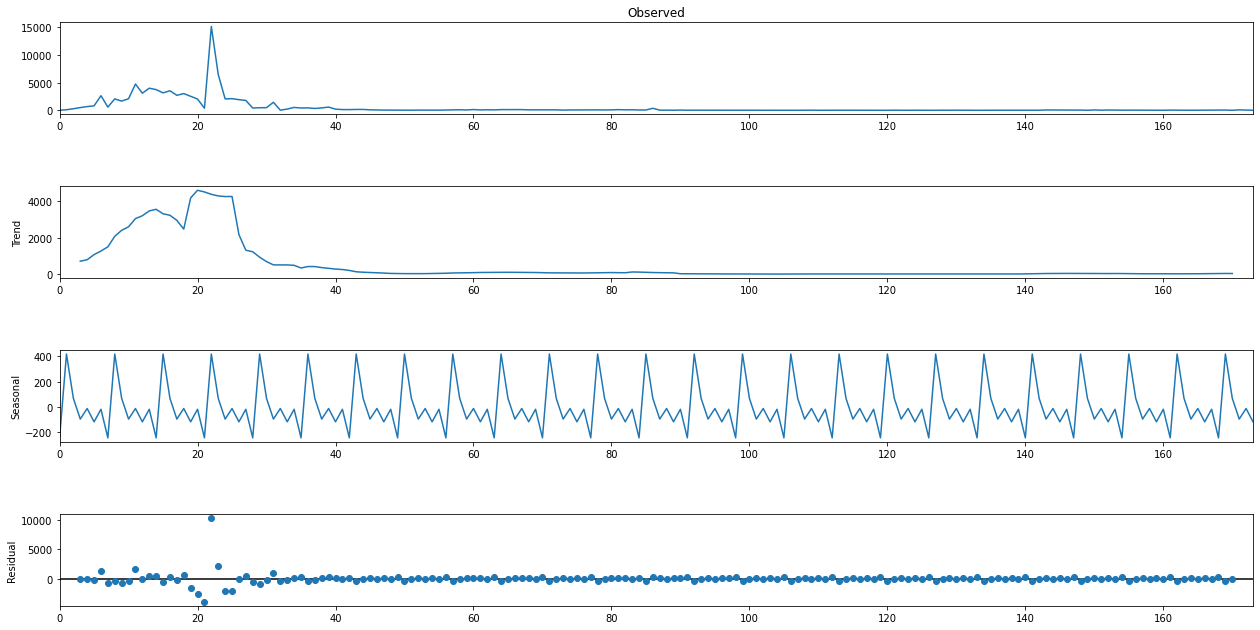

In [65]:
#taking increment in china's confirmed cases
# daily_increase_in_confirmed_cases_china = daily_increase_in_confirmed_cases.drop(last_7_days_for_forecasting, axis=1)
daily_increase_in_confirmed_cases_china = daily_increase_in_confirmed_cases[daily_increase_in_confirmed_cases["Country/Region"]=="china"]
daily_increase_in_confirmed_cases_china_values = daily_increase_in_confirmed_cases_china.drop(daily_increase_in_confirmed_cases_china.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_confirmed_cases_china_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition for increment in confirmed cases in USA**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

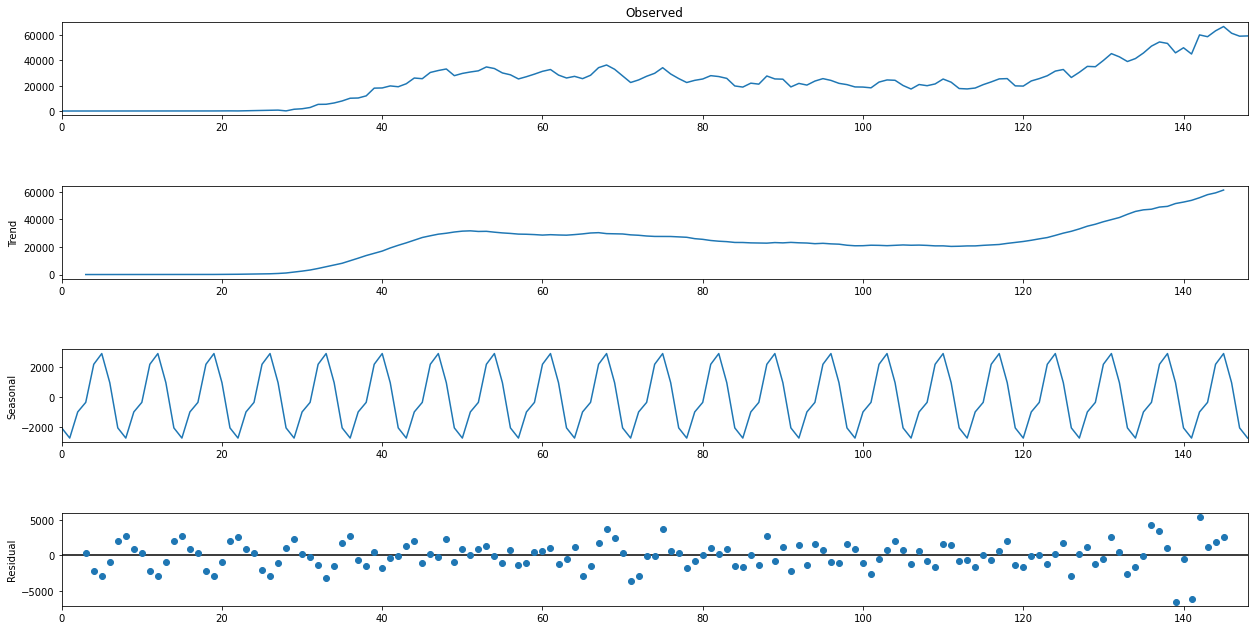

In [66]:
daily_increase_in_confirmed_cases_usa = daily_increase_in_confirmed_cases_after_16_feb[daily_increase_in_confirmed_cases_after_16_feb["Country/Region"]=="us"]
daily_increase_in_confirmed_cases_usa_values = daily_increase_in_confirmed_cases_usa.drop(daily_increase_in_confirmed_cases_usa.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_confirmed_cases_usa_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition for increment in confirmed cases in India**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

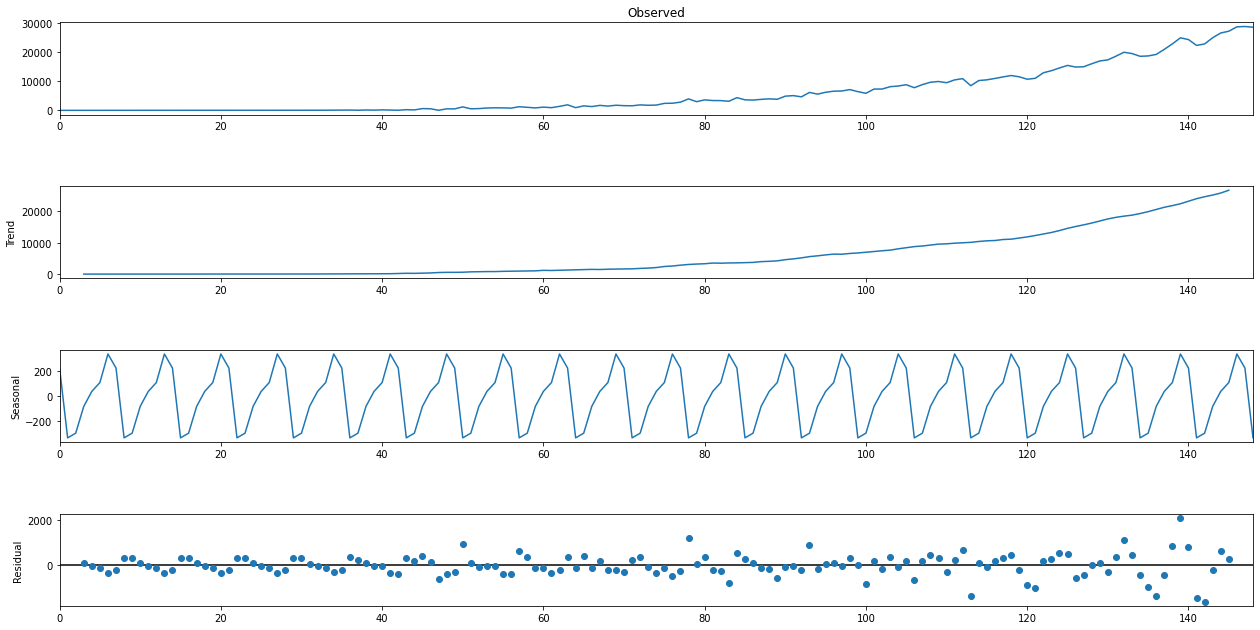

In [67]:
daily_increase_in_confirmed_cases_india = daily_increase_in_confirmed_cases_after_16_feb[daily_increase_in_confirmed_cases_after_16_feb["Country/Region"]=="india"]
daily_increase_in_confirmed_cases_india_values = daily_increase_in_confirmed_cases_india.drop(daily_increase_in_confirmed_cases_india.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_confirmed_cases_india_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

**Seasonal Decomposition for increment in confirmed cases in Brazil**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning:

the 'freq'' keyword is deprecated, use 'period' instead



<Figure size 432x288 with 0 Axes>

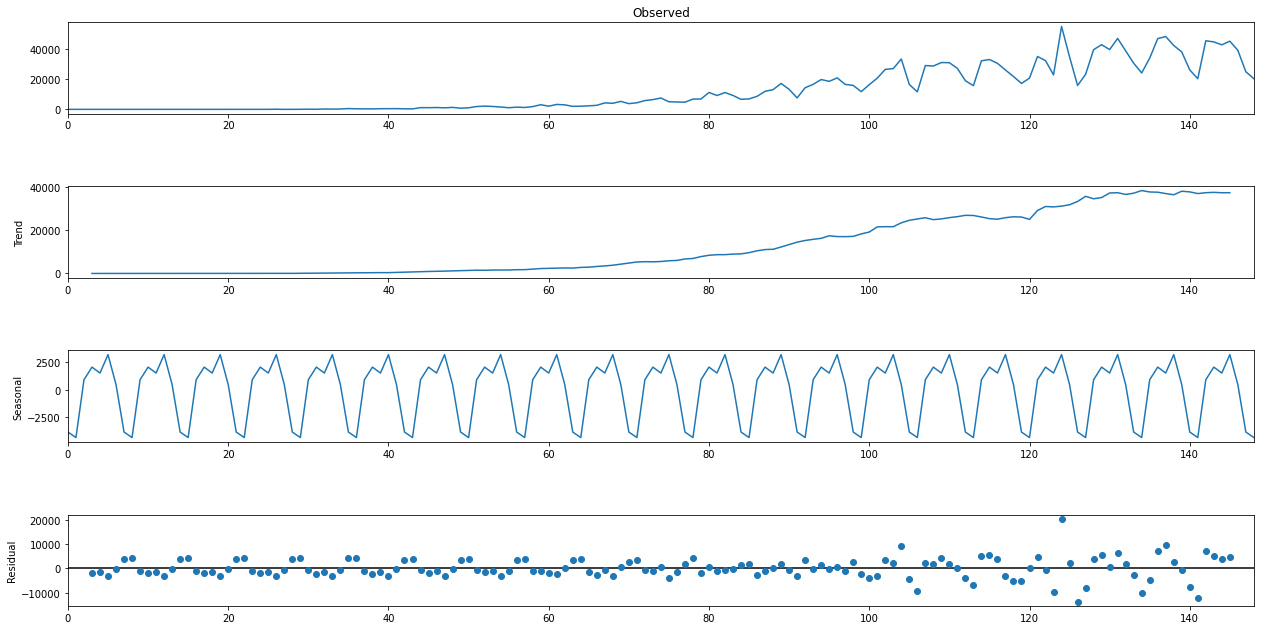

In [68]:
daily_increase_in_confirmed_cases_brazil = daily_increase_in_confirmed_cases_after_16_feb[daily_increase_in_confirmed_cases_after_16_feb["Country/Region"]=="brazil"]
daily_increase_in_confirmed_cases_brazil_values = daily_increase_in_confirmed_cases_brazil.drop(daily_increase_in_confirmed_cases_brazil.columns[0], axis=1).values.ravel()

# decomposition of daily footfall  : period = 7 days 
decomposition = seasonal_decompose(daily_increase_in_confirmed_cases_brazil_values, freq =7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

# Building ARIMA model country wise

In [10]:
!pip install pmdarima

In [70]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima.utils import ndiffs
import pandas as pd
import numpy as np
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from dateutil.relativedelta import relativedelta

## 5.1 : Estimating the differencing term

country_model = {}
# print(countries)
for country in countries.values.ravel():
    print(country)
    data = daily_increase_in_confirmed_cases[daily_increase_in_confirmed_cases["Country/Region"]==country]
    data = data.drop(["Country/Region"]+last_7_days_for_forecasting, axis=1)
    if country!="china":
        data = data.drop(before_16_feb_columns, axis=1)
    data = data.values.ravel()
    kpss_diffs = ndiffs(data, alpha=0.05, test='kpss', max_d=6)
    adf_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
    n_diffs = max(adf_diffs, kpss_diffs)

    model_auto = pm.auto_arima(data, start_p=1, start_q=1,
    #                     test='adf',       # use adftest to find optimal 'd'
                        max_p=5, max_q=5, # maximum p and q 
                        m=1,              # frequency of series
                        d=n_diffs,        
                        seasonal=False,   # No Seasonality
                        start_P=0, 
                        D=0, 
                        trace=True,
                        error_action='ignore',  
                        suppress_warnings=True, 
                        stepwise=True)
    country_model[country]=model_auto

# print(model_auto.summary())
# model_auto.plot_diagnostics(figsize=(7,7))
# plt.show()
# print(dir(model_auto))
# fc, se, conf = model_auto.predict(1, alpha=0.05)



afghanistan
Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=1649.809, BIC=1661.604, Time=0.140 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1695.319, BIC=1701.217, Time=0.011 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=1663.689, BIC=1672.536, Time=0.061 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=1649.088, BIC=1657.935, Time=0.074 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1693.362, BIC=1696.311, Time=0.010 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=1648.859, BIC=1660.654, Time=0.131 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=1650.024, BIC=1664.768, Time=0.187 seconds
Fit ARIMA(0,1,3)x(0,0,0,0) [intercept=True]; AIC=1643.515, BIC=1658.259, Time=0.204 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=1645.153, BIC=1662.846, Time=0.302 seconds
Fit ARIMA(0,1,4)x(0,0,0,0) [intercept=True]; AIC=1645.500, BIC=1663.192, Time=0.279 seconds
Fit ARIMA(1,1,4)x(0,0,0,

**Predictions of increment in daily confirmed cases**

In [84]:
prediction_countries = ["india"]
for country in prediction_countries:
    print("Predicted Increment in daily confirmed cases in {} for next 7 days are: {}".format(country.upper(), country_model[country].predict(7, alpha=0.05).tolist()))

print("----------------------------------------------------------")
for country in prediction_countries:
    actual_increment = daily_increase_in_confirmed_cases[daily_increase_in_confirmed_cases["Country/Region"]==country].iloc[:,168:175].values.ravel().tolist()
    print("Actual Increment in daily confirmed cases in {} for next 7 days are: {}".format(country.upper(), actual_increment))


Predicted Increment in daily confirmed cases in INDIA for next 7 days are: [22989.202120129696, 23487.342700046556, 23801.24729098216, 24356.088400413704, 24696.07041846311, 25230.945619325346, 25604.31805941343]
----------------------------------------------------------
Actual Increment in daily confirmed cases in INDIA for next 7 days are: [22753.0, 24879.0, 26506.0, 27114.0, 28606.0, 28732.0, 28498.0]


Accuracy metrics

In [ ]:
### Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})



# Predicting the increment in confirmed cases world_wide

**Algo:**
1. initialize world_total_confirm_cases = 0
2. for every country predict the increment in confirmed cases
    >new_confirmed_cases_for_the_country =  increment in confirmed cases+ confirmed cases on previous day for that country.

    >world_total_confirm_cases = world_total_confirm_cases + new_confirmed_cases_for_the_country



# Future Improvement/Steps

Since We have inadequate data to predict the confirm cases

it would be better if we can have 
1. daily basis hospital data, 
2. daily basis lockdown period data,
3. daily basis people tracedown data
4. travel history data
5. Persons Health data

